# Importing HRR Data

#### Variables & Features
In this portion, I will be importing the relavent variables for a 1 year span.

1. Weather
    1. Planetary Boundary Layer Height (HPBL)
    2. Wind speed U-vector: 10m above ground (UGRD)
    3. Wind speed V-vector: 10m above ground (VGRD)
    4. Temperature (TMP)
    5. Relative Humidity (RH)

In [7]:
import dataclasses
import datetime
import numpy as np
import pandas as pd
import zipfile
import glob
import matplotlib.pyplot as plt
import rioxarray
from PIL import Image
import rasterio
from rasterio.plot import show
import s3fs
import xarray as xr
import cartopy.crs as ccrs
import metpy
import boto3
from botocore import UNSIGNED
from botocore.config import Config
from botocore.exceptions import ClientError
import numcodecs as ncd

@dataclasses.dataclass
class ZarrId:
    run_hour: datetime.datetime
    level_type: str
    var_level: str
    var_name: str
    model_type: str
        
    def format_chunk_id(self, chunk_id):
        if self.model_type == "fcst": 
            return "0." + str(chunk_id)
        else:
            return chunk_id


# Define grid
fs = s3fs.S3FileSystem(anon=True)
chunk_index = xr.open_zarr(s3fs.S3Map("s3://hrrrzarr/grid/HRRR_chunk_index.zarr", s3=fs))
lat_top = 40
lat_bottom = 35
lon_top = -120
lon_bottom = -125


def check_boundaries(data):
    return (lat_bottom < data.latitude) & (data.latitude < lat_top) & (
        lon_bottom < data.longitude) & (data.longitude < lon_top)

def create_s3_group_url(zarr_id, prefix=True):
    url = "s3://hrrrzarr/" if prefix else ""
    url += zarr_id.run_hour.strftime(
        f"{zarr_id.level_type}/%Y%m%d/%Y%m%d_%Hz_{zarr_id.model_type}.zarr/")
    url += f"{zarr_id.var_level}/{zarr_id.var_name}"
    return url

def create_s3_subgroup_url(zarr_id, prefix=True):
    url = create_s3_group_url(zarr_id, prefix)
    url += f"/{zarr_id.var_level}"
    return url

def create_s3_chunk_url(zarr_id, chunk_id, prefix=False):
    url = create_s3_subgroup_url(zarr_id, prefix)
    url += f"/{zarr_id.var_name}/{zarr_id.format_chunk_id(chunk_id)}"
    return url

def get_unique(data):
    data = data.fillna(None).values.flatten()
    data = data[data != None]
    return np.unique(data)

def retrieve_object(s3, s3_url):
    obj = s3.Object('hrrrzarr', s3_url)
    return obj.get()['Body'].read()


def decompress_chunk(zarr_id, compressed_data):
    buffer = ncd.blosc.decompress(compressed_data)
    
    dtype = "<f2"
    if zarr_id.var_level == "surface" and zarr_id.var_name == "PRES":
        dtype = "<f4"
        
    chunk = np.frombuffer(buffer, dtype=dtype)
    
    if zarr_id.model_type == "anl":
        data_array = np.reshape(chunk, (150, 150))
    else:
        entry_size = 22500
        data_array = np.reshape(chunk, (len(chunk)//entry_size, 150, 150))
        
    return data_array

def get_chunk(zarr_id, chunk_id):
    # retrieve data as before
    compressed_data = retrieve_object(s3, create_s3_chunk_url(zarr_id, chunk_id))
    chunk_data = decompress_chunk(zarr_id, compressed_data)
    
    # combine retrieved data with the chunk grid
    chunk_xarray = chunk_index.where(lambda x: x.chunk_id == chunk_id, drop=True)
    dimensions = ("y", "x") if zarr_id.model_type == "anl" else ("time", "y", "x")
    chunk_xarray[zarr_id.var_name] = (dimensions, chunk_data)
    return chunk_xarray

def get_chunks_combined(zarr_id, chunk_ids):
    chunks = [get_chunk(zarr_id, chunk_id) for chunk_id in chunk_ids]
    return xr.merge(chunks)

def get_data(zarr_ids, chunk_ids, is_forecast):
    datasets = []
    for zarr_id in zarr_ids:
        try:
            data = get_chunks_combined(zarr_id, chunk_ids)
            data = data.where(check_boundaries, drop=True)
            new_time_dimension = "run_time" if is_forecast else "time"
            data[new_time_dimension] = zarr_id.run_hour
            datasets.append(data)
        except ClientError as ex:
            if ex.response['Error']['Code'] == 'NoSuchKey':
                continue
    ds = xr.concat(datasets, dim=new_time_dimension, combine_attrs="override")
    return ds


# Define time span
start = datetime.datetime(2018, 1, 3, 0)
times = [start + datetime.timedelta(hours=hour_delta) for hour_delta in range(5)]

# Define chunk IDs
s3 = boto3.resource(service_name='s3', region_name='us-west-1', config=Config(signature_version=UNSIGNED))
area = chunk_index.where(check_boundaries, drop=True)
chunk_ids = get_unique(area.chunk_id)


#HPBL
zarr_id_HPBL = ZarrId(
                run_hour=datetime.datetime(2018, 1, 3, 0),
                level_type="sfc",
                var_level="surface",
                var_name="HPBL",
                model_type="anl"
                )
zarr_ids_HPBL = [dataclasses.replace(zarr_id_HPBL, run_hour=time) for time in times]
HPBL_year = get_data(zarr_ids_HPBL, chunk_ids, False)
HPBL_year['HPBL'] = HPBL_year['HPBL'].astype('float64')
HPBL_year.to_netcdf('HPBL_year_2.nc')

/global/software/sl-7.x86_64/modules/langs/python/3.10/lib/python3.10/site-packages/xarray/conventions.py:205: SerializationWarning: variable chunk_id has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  warnings.warn(


In [8]:
xr.open_dataset('HPBL_year_2.nc')

<xarray.Dataset>
Dimensions:     (time: 4, x: 191, y: 218)
Coordinates:
  * x           (x) float64 -2.47e+06 -2.467e+06 ... -1.903e+06 -1.9e+06
  * y           (y) float64 -1.383e+05 -1.353e+05 ... 5.097e+05 5.127e+05
  * time        (time) datetime64[ns] 2018-01-03 ... 2018-01-03T04:00:00
Data variables:
    chunk_id    (time, x, y) object ...
    chunk_x     (time, x, y) float64 ...
    chunk_y     (time, y, x) float64 ...
    in_chunk_x  (time, x, y) float64 ...
    in_chunk_y  (time, y, x) float64 ...
    index_x     (time, x, y) float64 ...
    index_y     (time, y, x) float64 ...
    latitude    (time, y, x) float64 ...
    longitude   (time, y, x) float64 ...
    HPBL        (time, y, x) float64 ...

In [5]:
# RH
zarr_id_RH = ZarrId(
                run_hour=datetime.datetime(2018, 1, 3, 0),
                level_type="sfc",
                var_level="2m_above_ground",
                var_name="RH",
                model_type="anl"
                )
zarr_ids_RH = [dataclasses.replace(zarr_id_RH, run_hour=time) for time in times]
RH_year = get_data(zarr_ids_RH, chunk_ids, False)
RH_year['RH'] = RH_year['RH'].astype('float64')
RH_year.to_netcdf('RH_year.nc')

/global/software/sl-7.x86_64/modules/langs/python/3.10/lib/python3.10/site-packages/xarray/conventions.py:205: SerializationWarning: variable chunk_id has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  warnings.warn(


In [6]:
HPBL_year.to_netcdf('/scratch/HRRR_Import/file_attempt.nc')

PermissionError: [Errno 13] Permission denied: '/scratch/HRRR_Import/file_attempt.nc'

In [26]:
HPBL_year#.HPBL.to_netcdf('short_attempt.nc')

<xarray.Dataset>
Dimensions:     (time: 2, x: 191, y: 218)
Coordinates:
  * x           (x) float64 -2.47e+06 -2.467e+06 ... -1.903e+06 -1.9e+06
  * y           (y) float64 -1.383e+05 -1.353e+05 ... 5.097e+05 5.127e+05
  * time        (time) datetime64[ns] 2018-01-03 2018-01-03T01:00:00
Data variables:
    chunk_id    (time, x, y) object dask.array<chunksize=(1, 149, 47), meta=np.ndarray>
    chunk_x     (time, x, y) float64 dask.array<chunksize=(1, 149, 47), meta=np.ndarray>
    chunk_y     (time, y, x) float64 dask.array<chunksize=(1, 47, 149), meta=np.ndarray>
    in_chunk_x  (time, x, y) float64 dask.array<chunksize=(1, 149, 47), meta=np.ndarray>
    in_chunk_y  (time, y, x) float64 dask.array<chunksize=(1, 47, 149), meta=np.ndarray>
    index_x     (time, x, y) float64 dask.array<chunksize=(1, 149, 47), meta=np.ndarray>
    index_y     (time, y, x) float64 dask.array<chunksize=(1, 47, 149), meta=np.ndarray>
    latitude    (time, y, x) float64 dask.array<chunksize=(1, 47, 149), meta=np.ndarray>
    longitude   (time, y, x) float64 dask.array<chunksize=(1, 47, 149), meta=np.ndarray>
    HPBL        (time, y, x) float16 dask.array<chunksize=(1, 47, 149), meta=np.ndarray>

In [29]:
HPBL_year_fixed = HPBL_year#['HPBL'].astype('float64')
HPBL_year_fixed['HPBL'] = HPBL_year['HPBL'].astype('float64')
HPBL_year_fixed.to_netcdf('short_attempt.nc')

/global/software/sl-7.x86_64/modules/langs/python/3.10/lib/python3.10/site-packages/xarray/conventions.py:205: SerializationWarning: variable chunk_id has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  warnings.warn(


In [33]:
xr.open_dataset('short_attempt.nc')

<xarray.Dataset>
Dimensions:     (time: 2, x: 191, y: 218)
Coordinates:
  * x           (x) float64 -2.47e+06 -2.467e+06 ... -1.903e+06 -1.9e+06
  * y           (y) float64 -1.383e+05 -1.353e+05 ... 5.097e+05 5.127e+05
  * time        (time) datetime64[ns] 2018-01-03 2018-01-03T01:00:00
Data variables:
    chunk_id    (time, x, y) object ...
    chunk_x     (time, x, y) float64 ...
    chunk_y     (time, y, x) float64 ...
    in_chunk_x  (time, x, y) float64 ...
    in_chunk_y  (time, y, x) float64 ...
    index_x     (time, x, y) float64 ...
    index_y     (time, y, x) float64 ...
    latitude    (time, y, x) float64 ...
    longitude   (time, y, x) float64 ...
    HPBL        (time, y, x) float64 ...

In [9]:
import dataclasses
import datetime
import numpy as np
import pandas as pd
import zipfile
import glob
import matplotlib.pyplot as plt
import rioxarray
from PIL import Image
import rasterio
from rasterio.plot import show

## HPBL

In [10]:
import s3fs
import xarray as xr
import cartopy.crs as ccrs
import metpy
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import numcodecs as ncd

In [11]:
group_url = 's3://hrrrzarr/sfc/20180103/20180103_00z_anl.zarr/surface/HPBL'
subgroup_url = f"{group_url}/surface"

fs = s3fs.S3FileSystem(anon=True)    
ds = xr.open_mfdataset([s3fs.S3Map(url, s3=fs) for url in [group_url, subgroup_url]], engine='zarr')

projection = ccrs.LambertConformal(central_longitude=262.5, 
                                   central_latitude=38.5, 
                                   standard_parallels=(38.5, 38.5),
                                    globe=ccrs.Globe(semimajor_axis=6371229,
                                                     semiminor_axis=6371229))

ds = ds.rename(projection_x_coordinate="x", projection_y_coordinate="y")
ds = ds.metpy.assign_crs(projection.to_cf())
ds = ds.metpy.assign_latitude_longitude()    
ds#.UGRD.values

<xarray.Dataset>
Dimensions:                  (y: 1059, x: 1799)
Coordinates:
  * x                        (x) float64 -2.698e+06 -2.695e+06 ... 2.696e+06
  * y                        (y) float64 -1.587e+06 -1.584e+06 ... 1.587e+06
    metpy_crs                object Projection: lambert_conformal_conic
    latitude                 (y, x) float64 21.14 21.15 21.15 ... 47.85 47.84
    longitude                (y, x) float64 -122.7 -122.7 ... -60.95 -60.92
Data variables:
    HPBL                     (y, x) float16 dask.array<chunksize=(150, 150), meta=np.ndarray>
    forecast_period          timedelta64[ns] ...
    forecast_reference_time  datetime64[ns] ...
    height                   float64 ...
    pressure                 float64 ...
    time                     datetime64[ns] ...

Import methods for reading AWS weather files. The following code has been copied directly from MesoWest:

In [12]:
@dataclasses.dataclass
class ZarrId:
    run_hour: datetime.datetime
    level_type: str
    var_level: str
    var_name: str
    model_type: str
        
    def format_chunk_id(self, chunk_id):
        if self.model_type == "fcst": 
            # Extra id part since forecasts have an additional (time) dimension
            return "0." + str(chunk_id)
        else:
            return chunk_id

In [13]:
chunk_index = xr.open_zarr(s3fs.S3Map("s3://hrrrzarr/grid/HRRR_chunk_index.zarr", s3=fs))

lat_top = 40
lat_bottom = 35
lon_top = -120
lon_bottom = -125

def check_boundaries(data):
    return (lat_bottom < data.latitude) & (data.latitude < lat_top) & (
        lon_bottom < data.longitude) & (data.longitude < lon_top)

area = chunk_index.where(check_boundaries, drop=True)
area

<xarray.Dataset>
Dimensions:     (x: 191, y: 218)
Coordinates:
  * x           (x) float64 -2.47e+06 -2.467e+06 ... -1.903e+06 -1.9e+06
  * y           (y) float64 -1.383e+05 -1.353e+05 ... 5.097e+05 5.127e+05
Data variables:
    chunk_id    (x, y) object dask.array<chunksize=(149, 47), meta=np.ndarray>
    chunk_x     (x, y) float64 dask.array<chunksize=(191, 49), meta=np.ndarray>
    chunk_y     (y, x) float64 dask.array<chunksize=(49, 191), meta=np.ndarray>
    in_chunk_x  (x, y) float64 dask.array<chunksize=(191, 49), meta=np.ndarray>
    in_chunk_y  (y, x) float64 dask.array<chunksize=(49, 191), meta=np.ndarray>
    index_x     (x, y) float64 dask.array<chunksize=(191, 49), meta=np.ndarray>
    index_y     (y, x) float64 dask.array<chunksize=(49, 191), meta=np.ndarray>
    latitude    (y, x) float64 dask.array<chunksize=(49, 191), meta=np.ndarray>
    longitude   (y, x) float64 dask.array<chunksize=(49, 191), meta=np.ndarray>

In [6]:
def create_s3_group_url(zarr_id, prefix=True):
    url = "s3://hrrrzarr/" if prefix else ""
    url += zarr_id.run_hour.strftime(
        f"{zarr_id.level_type}/%Y%m%d/%Y%m%d_%Hz_{zarr_id.model_type}.zarr/")
    url += f"{zarr_id.var_level}/{zarr_id.var_name}"
    return url

def create_s3_chunk_url(zarr_id, chunk_id, prefix=False):
    url = create_s3_subgroup_url(zarr_id, prefix)
    url += f"/{zarr_id.var_name}/{zarr_id.format_chunk_id(chunk_id)}"
    return url

def create_s3_subgroup_url(zarr_id, prefix=True):
    url = create_s3_group_url(zarr_id, prefix)
    url += f"/{zarr_id.var_level}"
    return url

def create_s3_chunk_url(zarr_id, chunk_id, prefix=False):
    url = create_s3_subgroup_url(zarr_id, prefix)
    url += f"/{zarr_id.var_name}/{zarr_id.format_chunk_id(chunk_id)}"
    return url

In [14]:
def get_unique(data):
    # We have to implement our own "unique" logic since missing values are NaN (a float) and the rest are string
    data = data.fillna(None).values.flatten()
    data = data[data != None]
    return np.unique(data)

chunk_ids = get_unique(area.chunk_id)

In [7]:
s3 = boto3.resource(service_name='s3', region_name='us-west-1', config=Config(signature_version=UNSIGNED))

def retrieve_object(s3, s3_url):
    obj = s3.Object('hrrrzarr', s3_url)
    return obj.get()['Body'].read()

zarr_id = ZarrId(
                run_hour=datetime.datetime(2018, 1, 3, 0),
                level_type="sfc",
                var_level="surface",
                var_name="HPBL",
                model_type="anl"
                )

In [9]:
def get_chunk(zarr_id, chunk_id):
    # retrieve data as before
    compressed_data = retrieve_object(s3, create_s3_chunk_url(zarr_id, chunk_id))
    chunk_data = decompress_chunk(zarr_id, compressed_data)
    
    # combine retrieved data with the chunk grid
    chunk_xarray = chunk_index.where(lambda x: x.chunk_id == chunk_id, drop=True)
    dimensions = ("y", "x") if zarr_id.model_type == "anl" else ("time", "y", "x")
    chunk_xarray[zarr_id.var_name] = (dimensions, chunk_data)
    return chunk_xarray

def get_chunks_combined(zarr_id, chunk_ids):
    chunks = [get_chunk(zarr_id, chunk_id) for chunk_id in chunk_ids]
    return xr.merge(chunks)

    
data = get_chunks_combined(zarr_id, chunk_ids)
data = data.where(check_boundaries, drop=True)
data

In [21]:
data.HPBL.values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float16)

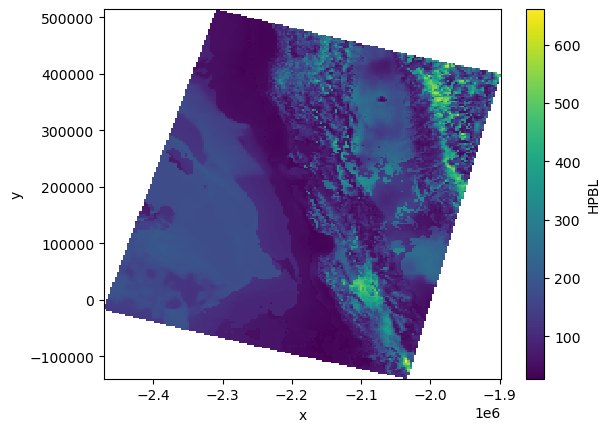

In [22]:
data.HPBL.plot()

In [10]:
start = datetime.datetime(2018, 1, 3, 0)
times = [start + datetime.timedelta(days=day_delta) for day_delta in range(2)]

zarr_ids = [dataclasses.replace(zarr_id, run_hour=time) for time in times]

def get_data(zarr_ids, chunk_ids, is_forecast):
    datasets = []
    for zarr_id in zarr_ids:
        data = get_chunks_combined(zarr_id, chunk_ids)
        data = data.where(check_boundaries, drop=True)
        new_time_dimension = "run_time" if is_forecast else "time"
        data[new_time_dimension] = zarr_id.run_hour
        datasets.append(data)
    ds = xr.concat(datasets, dim=new_time_dimension, combine_attrs="override")
    return ds
    
HPBL_year = get_data(zarr_ids, chunk_ids, False)
HPBL_year

NameError: name 'chunk_ids' is not defined

In [26]:
HPBL_year.HPBL.shape

(2, 218, 191)

## UGRD

In [27]:
zarr_id = ZarrId(
                run_hour=datetime.datetime(2018, 1, 3, 0),
                level_type="sfc",
                var_level="10m_above_ground",
                var_name="UGRD",
                model_type="anl"
                )
zarr_ids = [dataclasses.replace(zarr_id, run_hour=time) for time in times]

In [28]:
UGRD_year = get_data(zarr_ids, chunk_ids, False)
UGRD_year

<xarray.Dataset>
Dimensions:     (time: 2, x: 191, y: 218)
Coordinates:
  * x           (x) float64 -2.47e+06 -2.467e+06 ... -1.903e+06 -1.9e+06
  * y           (y) float64 -1.383e+05 -1.353e+05 ... 5.097e+05 5.127e+05
  * time        (time) datetime64[ns] 2018-01-03 2018-01-04
Data variables:
    chunk_id    (time, x, y) object dask.array<chunksize=(1, 149, 47), meta=np.ndarray>
    chunk_x     (time, x, y) float64 dask.array<chunksize=(1, 149, 47), meta=np.ndarray>
    chunk_y     (time, y, x) float64 dask.array<chunksize=(1, 47, 149), meta=np.ndarray>
    in_chunk_x  (time, x, y) float64 dask.array<chunksize=(1, 149, 47), meta=np.ndarray>
    in_chunk_y  (time, y, x) float64 dask.array<chunksize=(1, 47, 149), meta=np.ndarray>
    index_x     (time, x, y) float64 dask.array<chunksize=(1, 149, 47), meta=np.ndarray>
    index_y     (time, y, x) float64 dask.array<chunksize=(1, 47, 149), meta=np.ndarray>
    latitude    (time, y, x) float64 dask.array<chunksize=(1, 47, 149), meta=np.ndarray>
    longitude   (time, y, x) float64 dask.array<chunksize=(1, 47, 149), meta=np.ndarray>
    UGRD        (time, y, x) float16 dask.array<chunksize=(1, 47, 149), meta=np.ndarray>

In [11]:
UGRD_year.UGRD.shape

NameError: name 'UGRD_year' is not defined

## VGRD

In [30]:
zarr_id = ZarrId(
                run_hour=datetime.datetime(2018, 1, 3, 0),
                level_type="sfc",
                var_level="10m_above_ground",
                var_name="VGRD",
                model_type="anl"
                )
zarr_ids = [dataclasses.replace(zarr_id, run_hour=time) for time in times]

In [31]:
VGRD_year = get_data(zarr_ids, chunk_ids, False)
VGRD_year

<xarray.Dataset>
Dimensions:     (time: 2, x: 191, y: 218)
Coordinates:
  * x           (x) float64 -2.47e+06 -2.467e+06 ... -1.903e+06 -1.9e+06
  * y           (y) float64 -1.383e+05 -1.353e+05 ... 5.097e+05 5.127e+05
  * time        (time) datetime64[ns] 2018-01-03 2018-01-04
Data variables:
    chunk_id    (time, x, y) object dask.array<chunksize=(1, 149, 47), meta=np.ndarray>
    chunk_x     (time, x, y) float64 dask.array<chunksize=(1, 149, 47), meta=np.ndarray>
    chunk_y     (time, y, x) float64 dask.array<chunksize=(1, 47, 149), meta=np.ndarray>
    in_chunk_x  (time, x, y) float64 dask.array<chunksize=(1, 149, 47), meta=np.ndarray>
    in_chunk_y  (time, y, x) float64 dask.array<chunksize=(1, 47, 149), meta=np.ndarray>
    index_x     (time, x, y) float64 dask.array<chunksize=(1, 149, 47), meta=np.ndarray>
    index_y     (time, y, x) float64 dask.array<chunksize=(1, 47, 149), meta=np.ndarray>
    latitude    (time, y, x) float64 dask.array<chunksize=(1, 47, 149), meta=np.ndarray>
    longitude   (time, y, x) float64 dask.array<chunksize=(1, 47, 149), meta=np.ndarray>
    VGRD        (time, y, x) float16 dask.array<chunksize=(1, 47, 149), meta=np.ndarray>

In [32]:
VGRD_year.VGRD.shape

(2, 218, 191)

## TEMP

In [33]:
zarr_id = ZarrId(
                run_hour=datetime.datetime(2018, 1, 3, 0),
                level_type="sfc",
                var_level="2m_above_ground",
                var_name="TMP",
                model_type="anl"
                )
zarr_ids = [dataclasses.replace(zarr_id, run_hour=time) for time in times]

In [34]:
TEMP_year = get_data(zarr_ids, chunk_ids, False)
TEMP_year

<xarray.Dataset>
Dimensions:     (time: 2, x: 191, y: 218)
Coordinates:
  * x           (x) float64 -2.47e+06 -2.467e+06 ... -1.903e+06 -1.9e+06
  * y           (y) float64 -1.383e+05 -1.353e+05 ... 5.097e+05 5.127e+05
  * time        (time) datetime64[ns] 2018-01-03 2018-01-04
Data variables:
    chunk_id    (time, x, y) object dask.array<chunksize=(1, 149, 47), meta=np.ndarray>
    chunk_x     (time, x, y) float64 dask.array<chunksize=(1, 149, 47), meta=np.ndarray>
    chunk_y     (time, y, x) float64 dask.array<chunksize=(1, 47, 149), meta=np.ndarray>
    in_chunk_x  (time, x, y) float64 dask.array<chunksize=(1, 149, 47), meta=np.ndarray>
    in_chunk_y  (time, y, x) float64 dask.array<chunksize=(1, 47, 149), meta=np.ndarray>
    index_x     (time, x, y) float64 dask.array<chunksize=(1, 149, 47), meta=np.ndarray>
    index_y     (time, y, x) float64 dask.array<chunksize=(1, 47, 149), meta=np.ndarray>
    latitude    (time, y, x) float64 dask.array<chunksize=(1, 47, 149), meta=np.ndarray>
    longitude   (time, y, x) float64 dask.array<chunksize=(1, 47, 149), meta=np.ndarray>
    TMP         (time, y, x) float16 dask.array<chunksize=(1, 47, 149), meta=np.ndarray>

In [35]:
TEMP_year.TMP.shape

(2, 218, 191)

## RH

In [36]:
zarr_id = ZarrId(
                run_hour=datetime.datetime(2018, 1, 3, 0),
                level_type="sfc",
                var_level="2m_above_ground",
                var_name="TMP",
                model_type="anl"
                )
zarr_ids = [dataclasses.replace(zarr_id, run_hour=time) for time in times]

In [37]:
RH_year = get_data(zarr_ids, chunk_ids, False)
RH_year

<xarray.Dataset>
Dimensions:     (time: 2, x: 191, y: 218)
Coordinates:
  * x           (x) float64 -2.47e+06 -2.467e+06 ... -1.903e+06 -1.9e+06
  * y           (y) float64 -1.383e+05 -1.353e+05 ... 5.097e+05 5.127e+05
  * time        (time) datetime64[ns] 2018-01-03 2018-01-04
Data variables:
    chunk_id    (time, x, y) object dask.array<chunksize=(1, 149, 47), meta=np.ndarray>
    chunk_x     (time, x, y) float64 dask.array<chunksize=(1, 149, 47), meta=np.ndarray>
    chunk_y     (time, y, x) float64 dask.array<chunksize=(1, 47, 149), meta=np.ndarray>
    in_chunk_x  (time, x, y) float64 dask.array<chunksize=(1, 149, 47), meta=np.ndarray>
    in_chunk_y  (time, y, x) float64 dask.array<chunksize=(1, 47, 149), meta=np.ndarray>
    index_x     (time, x, y) float64 dask.array<chunksize=(1, 149, 47), meta=np.ndarray>
    index_y     (time, y, x) float64 dask.array<chunksize=(1, 47, 149), meta=np.ndarray>
    latitude    (time, y, x) float64 dask.array<chunksize=(1, 47, 149), meta=np.ndarray>
    longitude   (time, y, x) float64 dask.array<chunksize=(1, 47, 149), meta=np.ndarray>
    TMP         (time, y, x) float16 dask.array<chunksize=(1, 47, 149), meta=np.ndarray>

In [ ]:
RH_year.RH.shape